# sen2like in openEO

### sen2like

The Sen2Like, demonstration processor has been developed by ESA in the framework of the EU Copernicus programme (https://www.copernicus.eu/). The main goal of Sen2Like is to generate Sentinel-2 like harmonised/fused surface reflectances with higher periodicity by integrating additional compatible optical mission sensors.

https://github.com/senbox-org/sen2like

### openEO

openEO provides an option to run the sen2like processor on the requested extent on an openEO backend. The backend takes care of getting the required input data and the computational resources to run sen2like on. openEO users can start sen2like jobs on the backend and download the results as in the example given above.

https://openeo.cloud/

### Results

The outputs of sen2like are stored in Sentinel 2 - like .SAFE folders. In openEO, users can choose between the output formats NetCDF and GeoTiff. For the sen2like processing in openEO, it is now additionally possible to download the original .SAFE folders. Therefore, the export_original_files parameter needs to be set to True. (See below)

In [1]:
import openeo
from openeo.rest.datacube import PGNode, THIS

In [2]:
eodc = "https://openeo.eodc.eu/openeo/1.1.0/"

In [3]:
conn = openeo.connect(eodc).authenticate_oidc()

Authenticated using refresh token.


In [4]:
conn.describe_process("sen2like")

{'id': 'sen2like',
 'summary': 'Run the Sen2like processor ',
 'description': 'The Sen2like processor generates Sentinel-2-like harmonised or fused surface reflectances with higher periodicity by integrating additional compatible optical mission sensors. The source code is available at https://github.com/senbox-org/sen2like.',
 'categories': ['cubes'],
 'parameters': [{'name': 'data',
   'description': 'The datacube for which to generate L2F & L2H level data.',
   'optional': False,
   'schema': {'type': 'object', 'subtype': 'datacube'}},
  {'name': 'target_product',
   'description': "Per default the target_product is set to 'L2F' to generate the fused sen2like product. Set to 'L2H' to generate the harmonised product.",
   'optional': True,
   'default': 'L2F',
   'schema': {'type': 'string'}},
  {'name': 'cloud_cover',
   'description': 'The Cloud coverage parameter (percentage) to filter MGRS image tile contaminates with strong cloud coverage. ',
   'optional': True,
   'default': 50,
   'schema': {'type': ['number', 'null']}},
  {'name': 'export_original_files',
   'description': 'Sen2like produces outputs following the Sentinel 2 .SAFE convention. To enable the download for these, set this to True. The results will then include .zip files with the .SAFE folders inside. ',
   'optional': True,
   'default': False,
   'schema': {'type': 'boolean'}}],
 'returns': {'description': 'Sen2like enriched data cube for further processing. For further openEO processing on the sen2like datacube, the datacube is loaded in the Equi7 coordinate reference system, with the spatio-temporal extent of the initially requested data. The resolution is based on the highest resolution of the requested bands, where bands with lower resolution are resampled to the higher resolution respectively. ',
  'schema': {'type': 'object', 'subtype': 'datacube'}},
 'experimental': True,
 'links': [{'rel': 'about',
   'href': 'https://openeo.org/documentation/1.0/datacubes.html',
   'title': 'Data Cubes explained in the openEO documentation'},
  {'rel': 'about',
   'href': 'https://github.com/senbox-org/sen2like',
   'title': 'Source code for the sen2like processor'}]}

### Details in openEO's sen2like processing 

To create an openeo process graph, we define the spatial and temporal extent, we want to process. The bands which can be processed by sen2like are:
- 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11','B12'

For sen2like, we additionally set the parameters: 
- target_product, which can be L2F or L2H
- the cloud_cover, which is between 1 and 100. The lower the value, the lower the cloud cover for the files must be - files with higher cloud cover are ignored.
- export_original_files: can be True or False - if True, the .SAFE folders are an output of the openEO process as well.

In [5]:
collection      = 'SENTINEL2_L1C'
spatial_extent  = {"west": 15.6, "east": 15.7, "south": 46.5, "north": 46.6}
temporal_extent = ["2023-07-01", "2023-09-30"]
bands = ["B02", "B03", "B04"]

S2 = conn.load_collection(collection, spatial_extent=spatial_extent, temporal_extent=temporal_extent, bands=bands)
sen2like = S2.process('sen2like', {
    'data': THIS,
    'target_product': 'L2F', 
    'export_original_files': True,
    'cloud_cover': 50}) 

Additionally, we can make use of other openEO processes as shown below. The data is aggregated to produce monthly means and stored in NetCDF files.

In [6]:
sen2like_month = sen2like.aggregate_temporal_period(reducer="mean", period="month")

sen2like_nc = sen2like_month.save_result(format="NetCDF")

We create and start the openEO batch job:

In [9]:
job = sen2like_nc.create_job().start_job()

In [10]:
job

<BatchJob job_id='0161b48a-98d6-451a-abdb-84e58cac77c4'>

In [9]:
job.status()

'finished'

When the job is finished, the results can be downloaded. 

In [10]:
results = job.get_results()
metadata = results.get_metadata()

sen2like produces openEO NetCDF outputs per default in the Equi7 grid, as well as .SAFE files, both can be found in the metadata assets: E.g.: 

In [11]:
metadata['assets']['EU010M_E051N014T1_20230930T000000.nc']

{'href': 'https://openeo.eodc.eu/openeo/1.1.0/files/db4c5212-1900-4b44-98eb-beb201dd7efe/OPENEO/results/EU010M_E051N014T1_20230930T000000.nc?Expires=1710505168&KeyName=SIGN_KEY_1&UserId=2c3c496d-935a-4f39-b246-da2da4e07a6a&Signature=2yMenFI8tisCrdBZLSmC-6q3r4I=',
 'title': 'EU010M_E051N014T1_20230930T000000',
 'equi7:proj': '+proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=2121415.69617 +datum=WGS84 +units=m +no_defs',
 'roles': ['data']}

In [12]:
metadata['assets']['EU010M_E052N014T1_20230930T000000.nc']

{'href': 'https://openeo.eodc.eu/openeo/1.1.0/files/db4c5212-1900-4b44-98eb-beb201dd7efe/OPENEO/results/EU010M_E052N014T1_20230930T000000.nc?Expires=1710505168&KeyName=SIGN_KEY_1&UserId=2c3c496d-935a-4f39-b246-da2da4e07a6a&Signature=2_J-eQWAjBPeMl0tL7S6FJ6SAps=',
 'title': 'EU010M_E052N014T1_20230930T000000',
 'equi7:proj': '+proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=2121415.69617 +datum=WGS84 +units=m +no_defs',
 'roles': ['data']}

In [13]:
metadata['assets']['S2A_MSIL2F_20230815T095031_N0404_R079_T33TWM_20240308T095024.SAFE']

{'href': 'https://openeo.eodc.eu/openeo/1.1.0/files/db4c5212-1900-4b44-98eb-beb201dd7efe/OPENEO/results/S2A_MSIL2F_20230815T095031_N0404_R079_T33TWM_20240308T095024.zip?Expires=1710505168&KeyName=SIGN_KEY_1&UserId=2c3c496d-935a-4f39-b246-da2da4e07a6a&Signature=ADrPkUm8B_q_hICGC00Aw2Ec2KI=',
 'title': 'S2A_MSIL2F_20230815T095031_N0404_R079_T33TWM_20240308T095024',
 'proj:epsg': 32633,
 'roles': ['data']}

### Explore the openEO results

In [14]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt

In [15]:
data = xr.open_mfdataset("EU010M_E051N014T1_20230930T000000.nc")

data

<xarray.Dataset>
Dimensions:      (y: 1193, x: 755)
Coordinates:
  * y            (y) float64 1.446e+06 1.446e+06 ... 1.434e+06 1.434e+06
  * x            (x) float64 5.192e+06 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
    spatial_ref  int32 ...
    t            datetime64[ns] ...
Data variables:
    B02          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(1193, 755), meta=np.ndarray>
Attributes:
    nodata:   -9999
    crs:      PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WG...

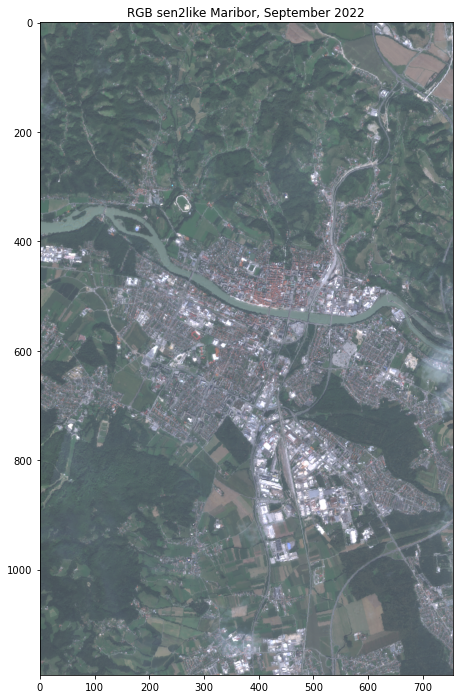

In [16]:
brg = np.zeros((data.B04.shape[0],data.B04.shape[1],3))
brg[:,:,0] = (data.B04.values+1)/15
brg[:,:,1] = (data.B03.values+1)/14
brg[:,:,2] = (data.B02.values+1)/11.6
brg = np.clip(brg,0,255).astype(np.uint8)

plt.figure(figsize=(8,12))
plt.title("RGB sen2like Maribor, September 2022")
plt.imshow(brg,cmap='brg')

### Auxiliary data (openEO takes care of the datasets)

Using openEO to process sen2like, the user does not have to take care of getting the input datasets - as they are provided by the backend. 

Not only does the backend provide you with the Sentinel 2 and Landsat 8 & 9 data, that is required, but it also includes all auxiliary data, needed by sen2like, automatically. Such as:

- CAMS data:
    Available data includes information about
    - Total Aerosol Optical Depth at 550nm
    - Total column water vapour
    - Mean sea level pressure
    - GEMS Total column ozone
- Sentinel 2 reference images:
    - Original source: https://s2gri.csgroup.space/
- Digital elevation model: 
    - Original source: https://sentinels.copernicus.eu/web/sentinel/-/copernicus-dem-new-direct-data-download-access
